# Spectrum simulation with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html) in order to simulate and fit spectra.

First, we will simulate and fit a pure power law without any background. Than we will add a power law shaped background component. Finally, we will see how to simulate and fit a user defined model. For all scenarios a toy detector will be simulated. For an example using real CTA IRFs, checkout [this notebook](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_simulation_cta.ipynb).

The following clases will be used:

* [gammapy.irf.EffectiveAreaTable](http://docs.gammapy.org/en/latest/api/gammapy.irf.EffectiveAreaTable.html)
* [gammapy.irf.EnergyDispersion](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDispersion)
* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.SpectralModel.html)

Feedback welcome!

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw, SpectralModel
from gammapy.utils.modeling import Parameter, ParameterList

## Create detector

For the sake of self consistency of this tutorial, we will simulate a simple detector. For a real application you would want to replace this part of the code with loading the IRFs or your detector (TODO: Link to IRFs tutorial)

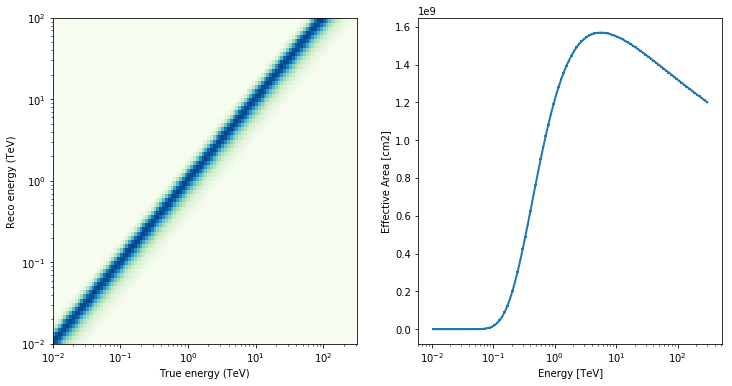

In [3]:
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2,2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2, bias=0)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
edisp.plot_matrix(ax=axes[0])
aeff.plot(ax=axes[1])

## Power law

In this section we will simulate one observation using a power law model.

In [4]:
index = 2.3 * u.Unit('')
amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

pwl = PowerLaw(index=index, amplitude=amplitude, reference=reference)
print(pwl)

livetime = 2 * u.h

PowerLaw

Parameters: 

	   name     value   error       unit      min max frozen
	--------- --------- ----- --------------- --- --- ------
	    index 2.300e+00   nan                 nan nan  False
	amplitude 1.000e-11   nan 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00   nan             TeV nan nan   True


In [5]:
sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime)
sim.simulate_obs(seed=2309, obs_id=1)
print(sim.obs)

*** Observation summary report ***
Observation Id: 1
Livetime: 2.000 h
On events: 339
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 339.00
Excess / Background: inf
Gamma rate: 0.04 1 / min
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 0.01 TeV - 100.00 TeV


/Users/deil/code/gammapy/gammapy/data/obs_stats.py:209: RuntimeWarning: divide by zero encountered in true_divide
  self.background))
/Users/deil/code/gammapy/gammapy/stats/poisson.py:385: RuntimeWarning: divide by zero encountered in log
  m = n_off * log(n_off * temp)
/Users/deil/code/gammapy/gammapy/stats/poisson.py:385: RuntimeWarning: invalid value encountered in multiply
  m = n_off * log(n_off * temp)


In [6]:
fit = SpectrumFit(obs_list=sim.obs, model=pwl.copy(), stat='cash')
fit.fit_range = [1, 10] * u.TeV
fit.fit()
fit.est_errors()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 2.259e+00 2.192e-01                 nan nan  False
	amplitude 9.255e-12 1.755e-12 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True

Covariance: 

	name/name  index   amplitude
	--------- -------- ---------
	    index   0.0481  2.99e-13
	amplitude 2.99e-13  3.08e-24 

Statistic: -74.059 (cash)
Fit Range: [ 1.          9.42668455] TeV



## Include background

In this section we will include a background component. Furthermore, we will also simulate more than one observation and fit each one individuallt in order to get average fit results.

In [7]:
bkg_index = 2.5 * u.Unit('')
bkg_amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

bkg_model = PowerLaw(index=bkg_index, amplitude=bkg_amplitude, reference=reference)
alpha = 0.2

In [8]:
n_obs = 10
seeds = np.arange(n_obs)

sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime,
                         background_model=bkg_model,
                         alpha=alpha)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

SpectrumObservationList
Number of observations: 10
*** Observation summary report ***
Observation Id: 0
Livetime: 2.000 h
On events: 733
Off events: 1915
Alpha: 0.200
Bkg events in On region: 383.00
Excess: 350.00
Excess / Background: 0.91
Gamma rate: 0.04 1 / min
Bkg rate: 0.04 1 / min
Sigma: 14.17
energy range: 0.01 TeV - 100.00 TeV


Before moving on to the fit let's have a look at the simulated observations

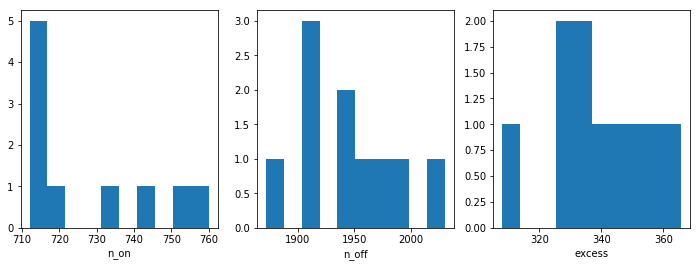

In [9]:
n_on = [obs.total_stats.n_on for obs in sim.result]
n_off = [obs.total_stats.n_off for obs in sim.result]
excess = [obs.total_stats.excess for obs in sim.result]

fix, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel('n_on')
axes[1].hist(n_off)
axes[1].set_xlabel('n_off')
axes[2].hist(excess)
axes[2].set_xlabel('excess')

In [10]:
best_fit_index = []

pwl.parameters['index'].parmax = 10
for obs in sim.result:
    fit = SpectrumFit(obs, pwl.copy(), stat='wstat')
    fit.model.parameters['index'].value = 2
    fit.fit()
    best_fit_index.append(fit.result[0].model.parameters['index'].value)

/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)


best_fit_index: [2.4210876310429703, 2.348343811183434, 2.3452606874153705, 2.2849302714618704, 2.1708828724555853, 2.1624319913222068, 2.3647918746839056, 2.3849072419290813, 2.3691150798628171, 2.1822751318255573]


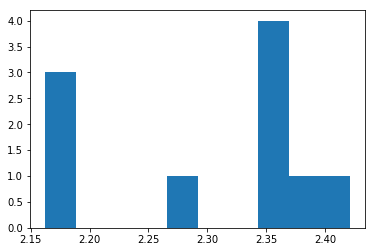

In [11]:
plt.hist(best_fit_index)
print('best_fit_index:', best_fit_index)

## Exercises

* Fit a pure power law and the user define model to the observation you just simulated. You can start with the user defined model described in the [spectrum_models.ipynb](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_models.ipynb) notebook.
* Vary the observation lifetime and see when you can distinguish the two models (Hint: You get the final likelihood of a fit from fit.result[0].statval).

## What's next

In this tutorial we learnd how to simulate and fit data using a toy detector. Go to [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html) to see what else you can do with gammapy.